In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'CFP.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-06-30,907,-587,320,64,108,147,482,820,0,...,0,143,0,495,153,1413,206,-63,139.9,2014-07-28
1,2014-09-30,838,-544,294,58,146,111,506,861,0,...,0,145,0,494,153,1427,120,-64,139.9,2014-10-28
2,2014-12-31,860,-592,269,41,158,91,518,903,81,...,0,68,0,255,229,1460,110,-55,135.3,2015-02-24
3,2015-03-31,930,-626,304,47,214,137,640,1113,0,...,0,183,0,616,229,1822,33,-46,135.3,2015-04-28
4,2015-06-30,952,-690,262,24,144,149,535,983,0,...,0,142,0,543,229,1739,134,-49,135.3,2015-07-28


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-06-30,2023-07-28,118.9,1446,-1139,308,-49,861,389,992,...,864,6287,0,64,72,882,160,2368,184,-142
37,2023-09-30,2023-10-28,118.9,1312,-1076,237,-35,838,356,917,...,867,6328,0,84,75,927,163,2399,206,-193
38,2023-12-31,2024-02-24,118.9,1283,-1067,216,-122,627,298,995,...,866,6131,0,111,75,905,115,2313,-8,-172
39,2024-03-31,2024-04-29,118.9,1468,-1117,351,-64,421,395,1122,...,861,6156,0,116,77,986,118,2394,-81,-103
40,2024-06-30,2024-07-22,118.6,1381,-1174,207,-186,411,392,928,...,854,6027,0,185,80,1067,119,2436,116,-170


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-06-30,2023-07-28,118.9,1446,-1139,308,-49,861,389,992,...,6287,0,64,72,882,160,2368,184,-142,1.343352
37,2023-09-30,2023-10-28,118.9,1312,-1076,237,-35,838,356,917,...,6328,0,84,75,927,163,2399,206,-193,1.341033
38,2023-12-31,2024-02-24,118.9,1283,-1067,216,-122,627,298,995,...,6131,0,111,75,905,115,2313,-8,-172,1.361617
39,2024-03-31,2024-04-29,118.9,1468,-1117,351,-64,421,395,1122,...,6156,0,116,77,986,118,2394,-81,-103,1.347550
40,2024-06-30,2024-07-22,118.6,1381,-1174,207,-186,411,392,928,...,6027,0,185,80,1067,119,2436,116,-170,1.367756


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-06-30,2023-07-28,118.9,1446,-1139,308,-49,861,389,992,...,6287,0,64,72,882,160,2368,184,-142,1.343352
37,2023-09-30,2023-10-28,118.9,1312,-1076,237,-35,838,356,917,...,6328,0,84,75,927,163,2399,206,-193,1.341033
38,2023-12-31,2024-02-24,118.9,1283,-1067,216,-122,627,298,995,...,6131,0,111,75,905,115,2313,-8,-172,1.361617
39,2024-03-31,2024-04-29,118.9,1468,-1117,351,-64,421,395,1122,...,6156,0,116,77,986,118,2394,-81,-103,1.347550
40,2024-06-30,2024-07-22,118.6,1381,-1174,207,-186,411,392,928,...,6027,0,185,80,1067,119,2436,116,-170,1.367756


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-07-28,22.770000,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.482986,0.517014,0.0,0.0,0.0,0.0,0.352811,0.070562,0.0,0.0
1,2014-08-04,21.969999,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.482986,0.517014,0.0,0.0,0.0,0.0,0.352811,0.070562,0.0,0.0
2,2014-08-11,22.870001,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.482986,0.517014,0.0,0.0,0.0,0.0,0.352811,0.070562,0.0,0.0
3,2014-08-18,25.350000,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.482986,0.517014,0.0,0.0,0.0,0.0,0.352811,0.070562,0.0,0.0
4,2014-08-25,25.219999,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.482986,0.517014,0.0,0.0,0.0,0.0,0.352811,0.070562,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-07-28,22.770000,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.0,0.352811,0.070562,0.0,0.0,inf,2.413275,inf,inf,inf
1,2014-08-04,21.969999,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.0,0.352811,0.070562,0.0,0.0,inf,2.328487,inf,inf,inf
2,2014-08-11,22.870001,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.0,0.352811,0.070562,0.0,0.0,inf,2.423874,inf,inf,inf
3,2014-08-18,25.350000,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.0,0.352811,0.070562,0.0,0.0,inf,2.686716,inf,inf,inf
4,2014-08-25,25.219999,2014-06-30,907.0,0.0,9.435311,139.9,0.0,0.0,108.0,...,0.0,0.352811,0.070562,0.0,0.0,inf,2.672938,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

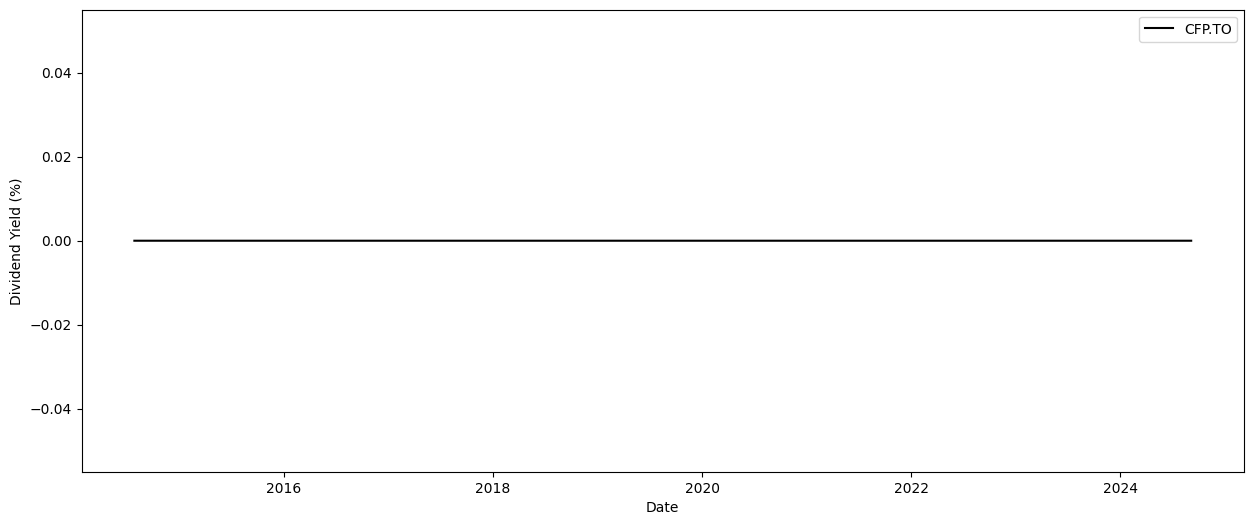

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.604042
share_price      1.000000
Name: share_price, dtype: float64


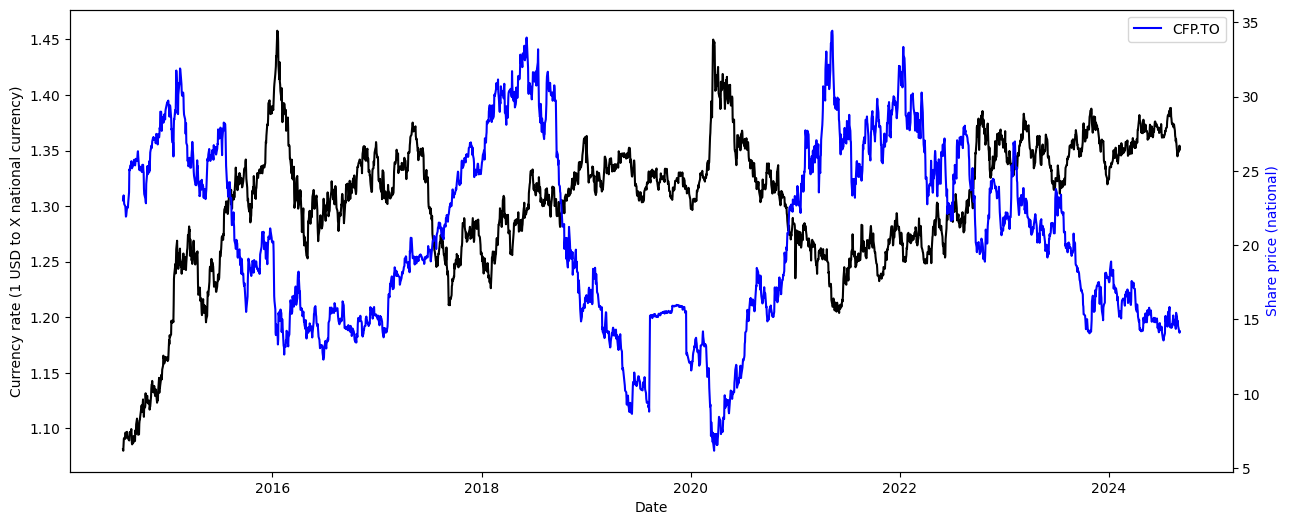

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

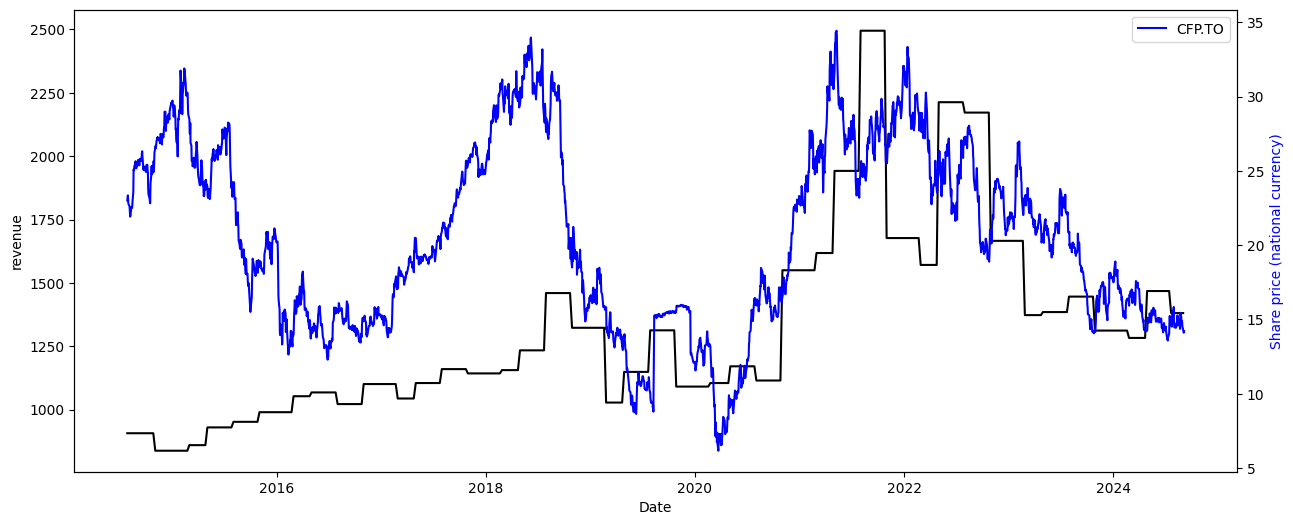

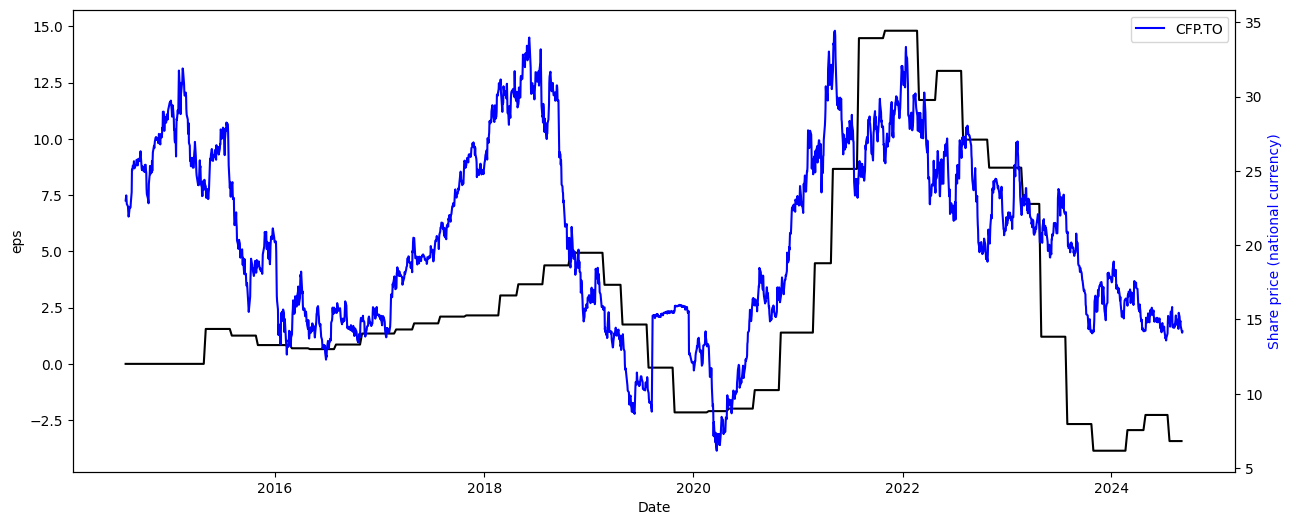

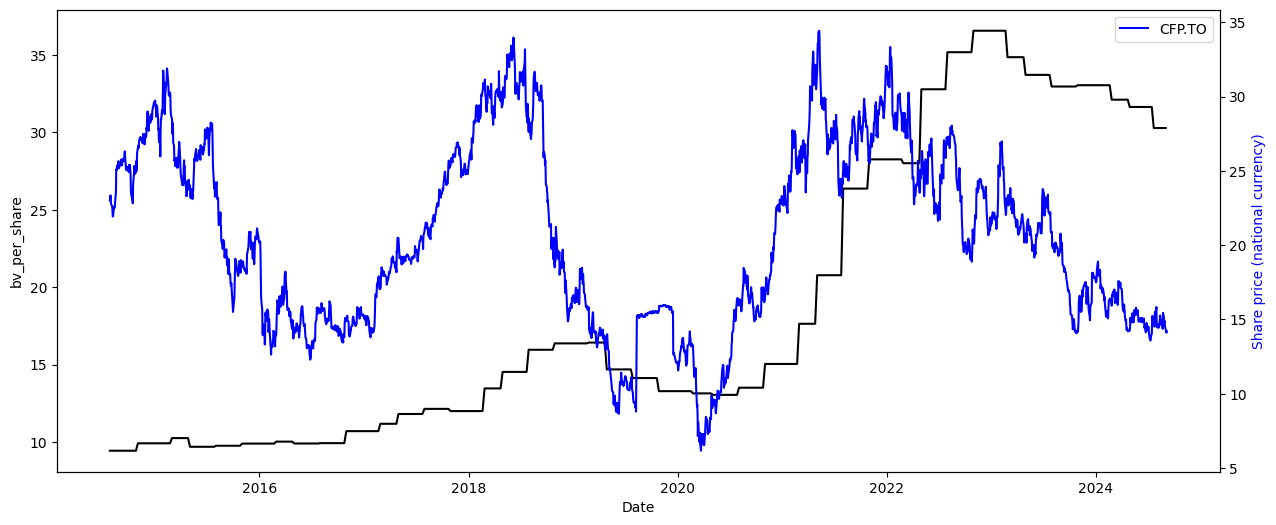

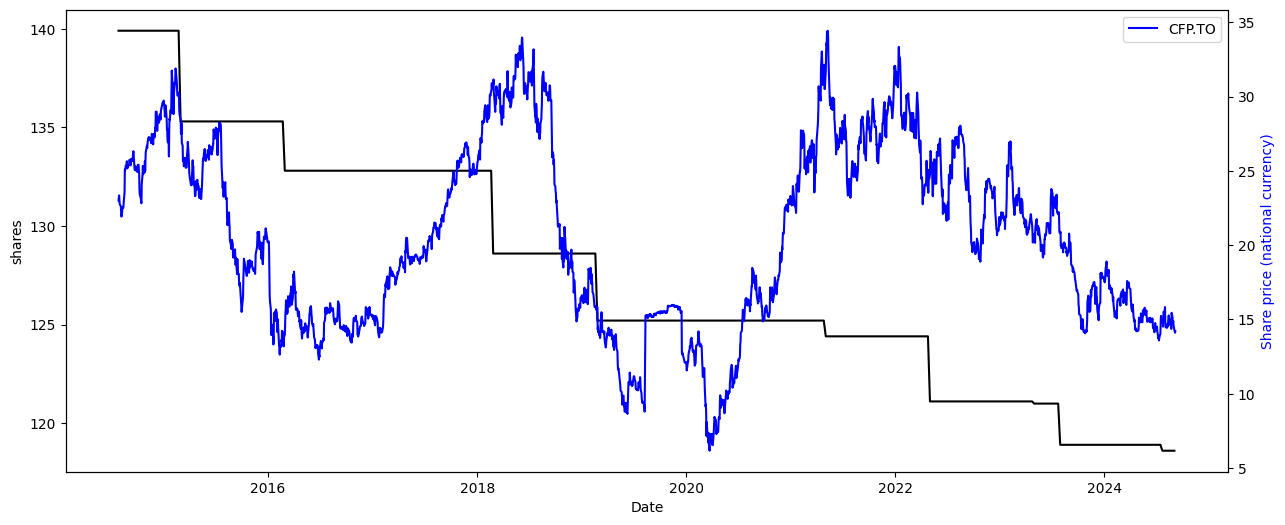

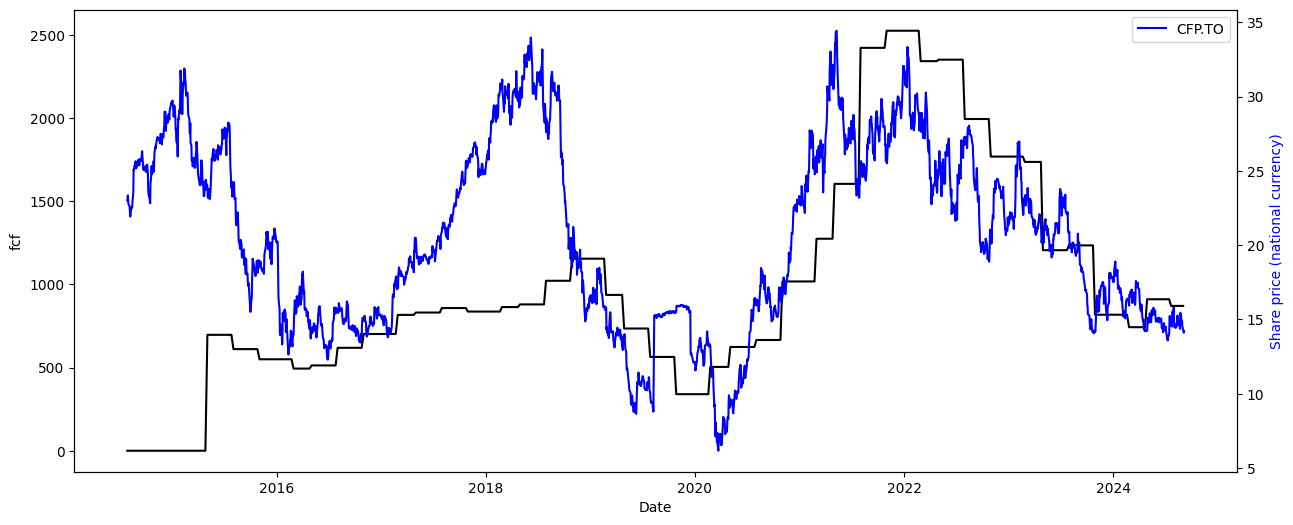

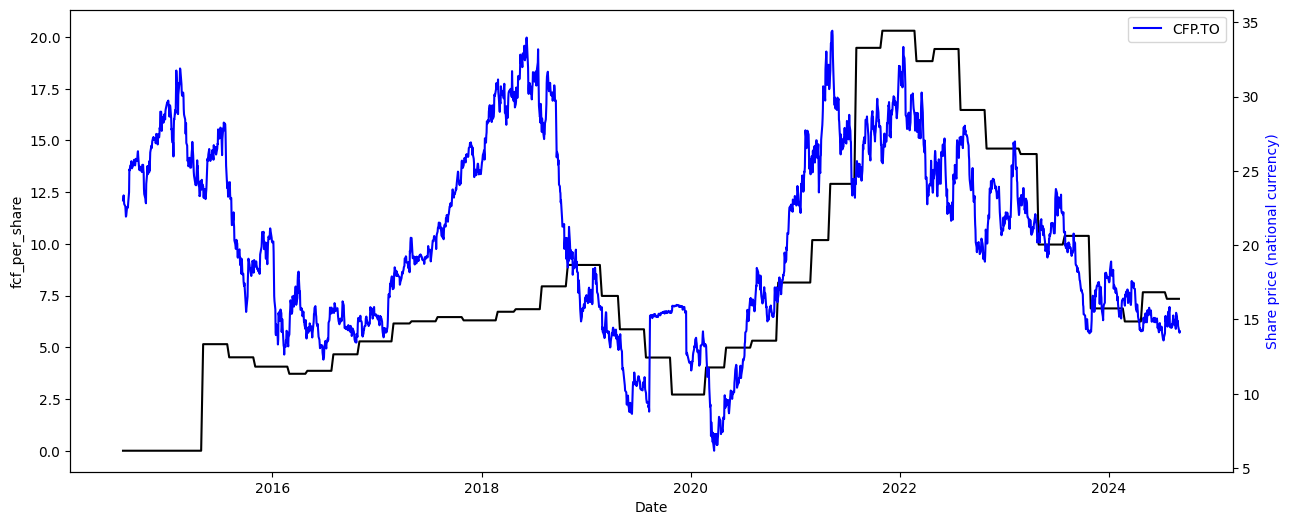

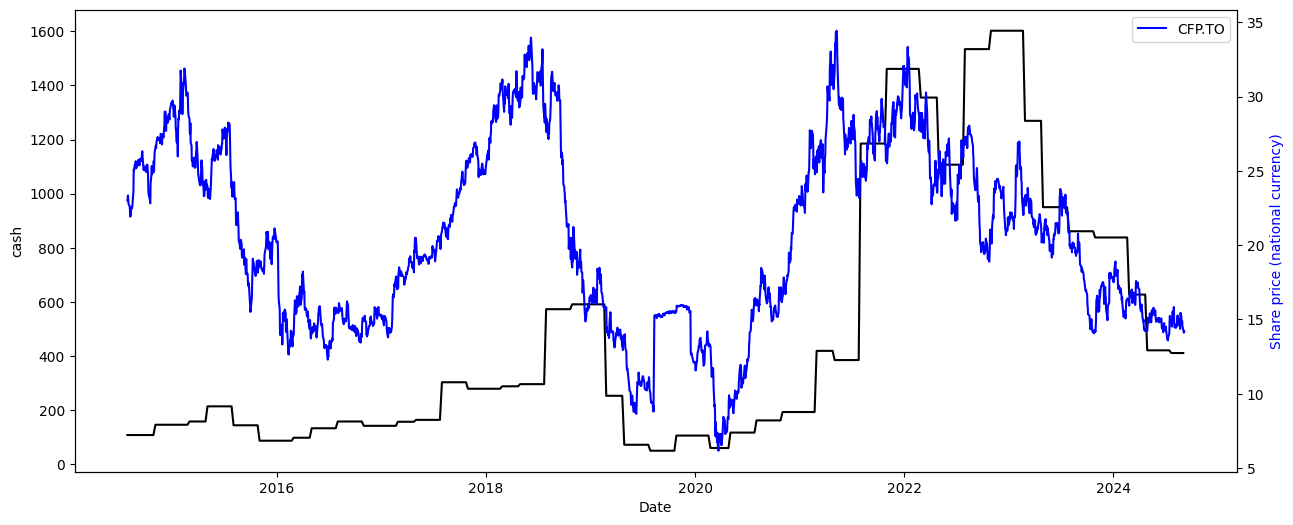

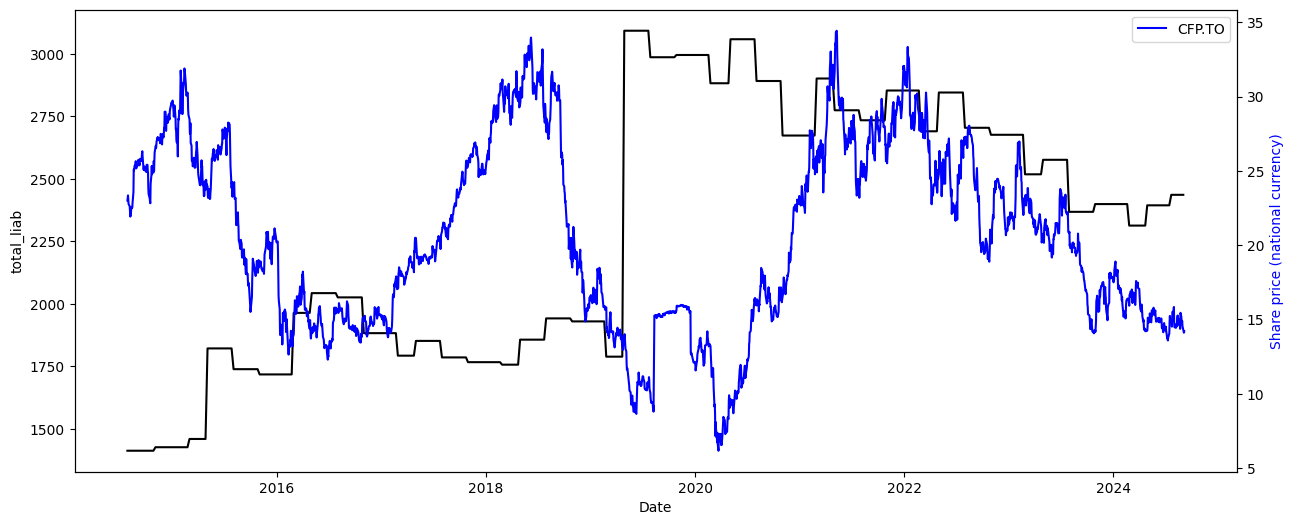

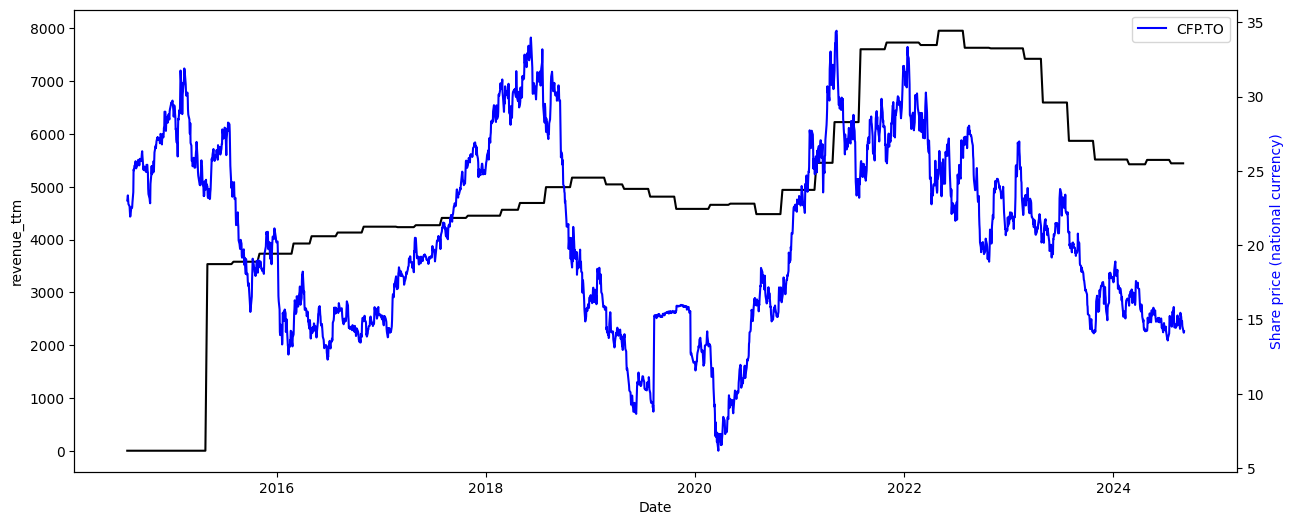

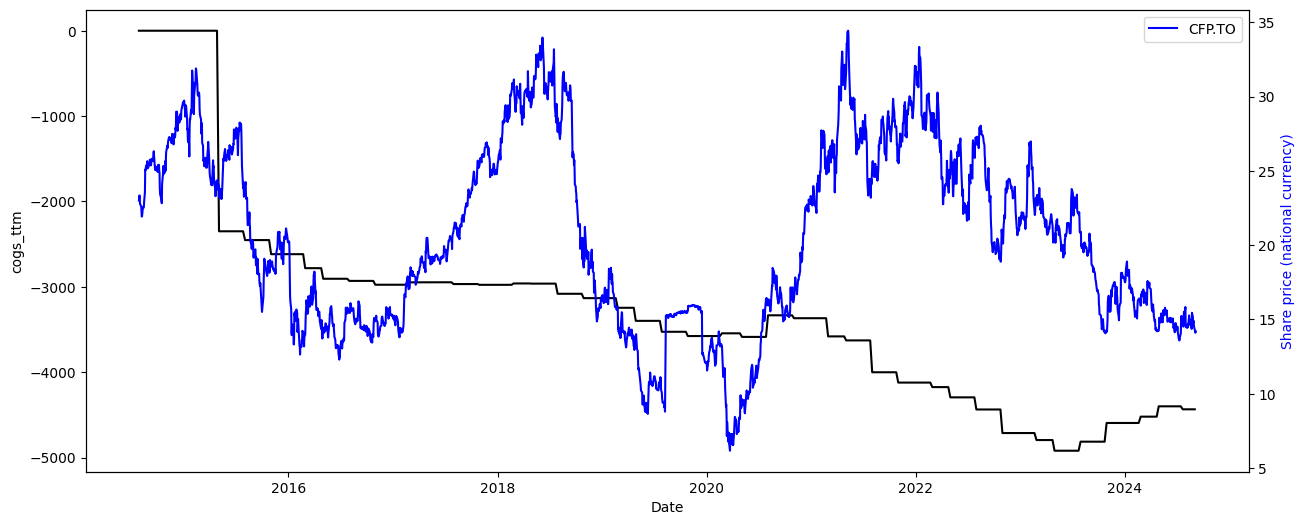

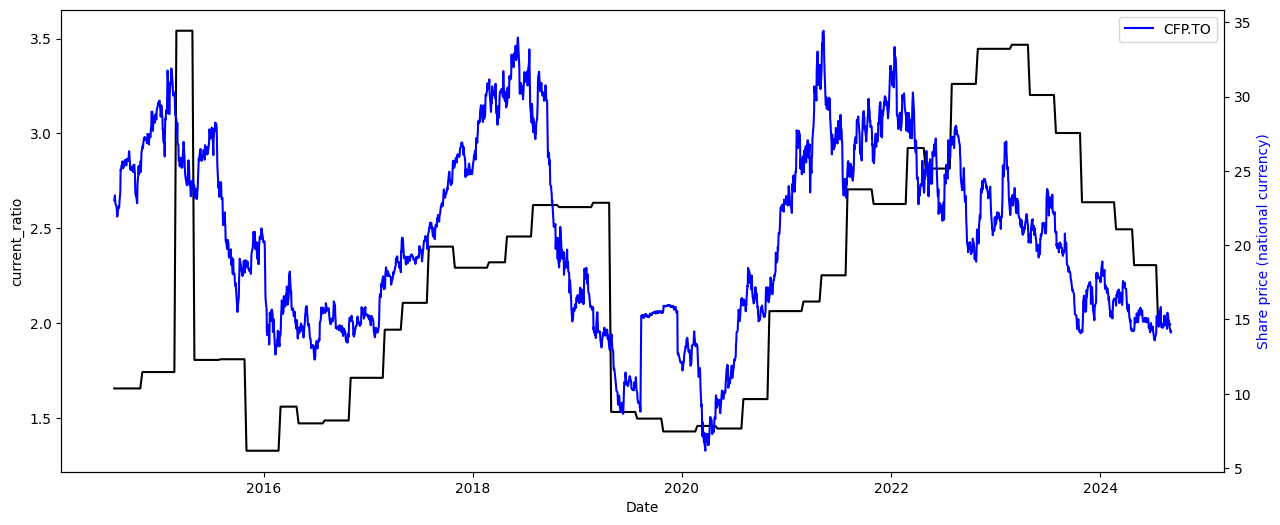

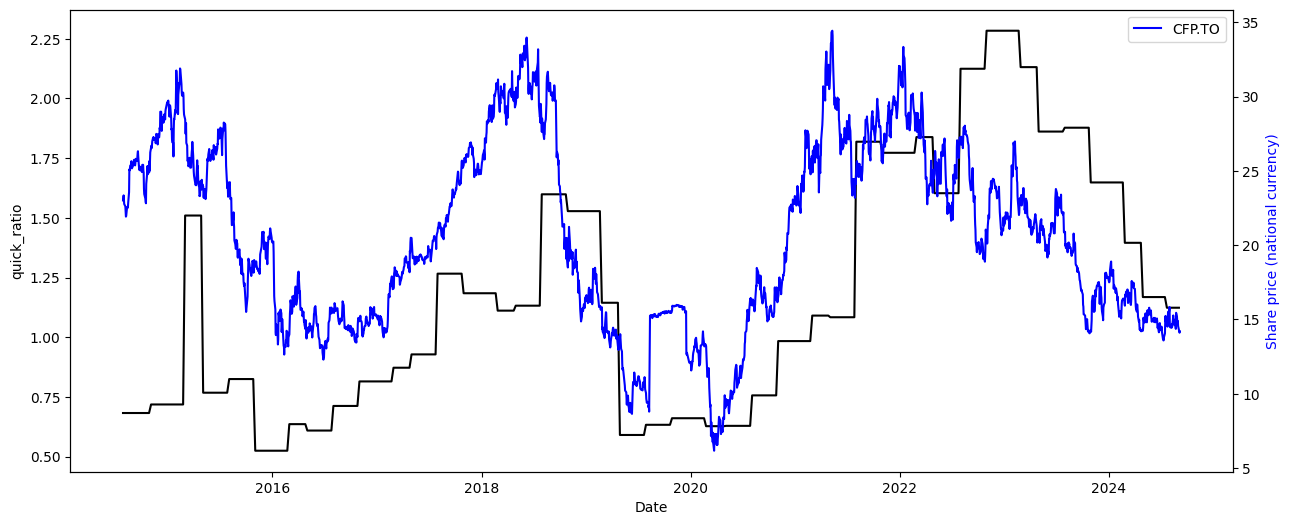

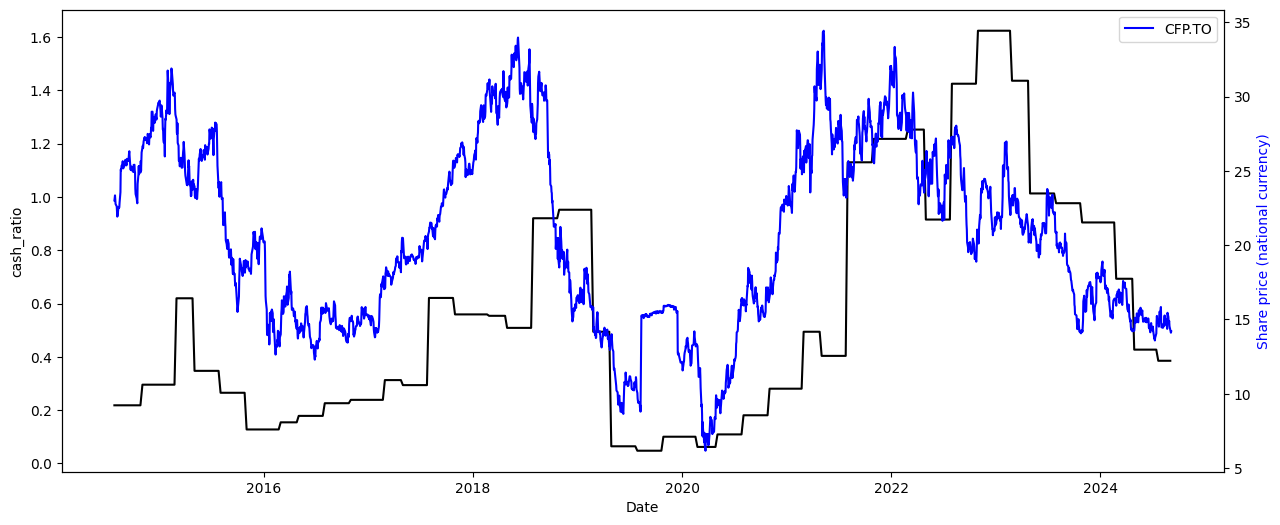

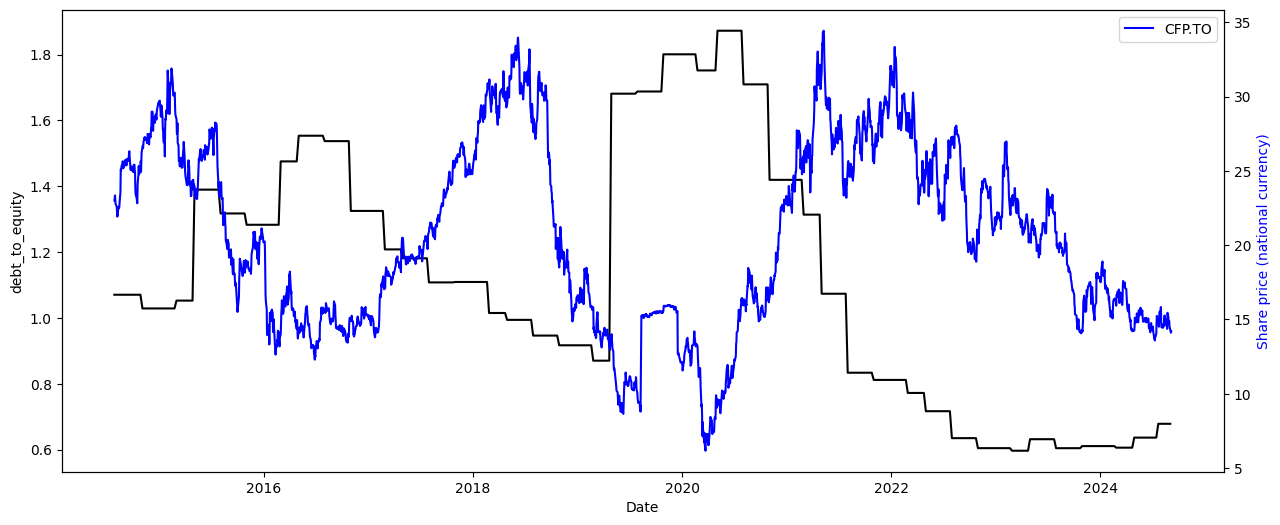

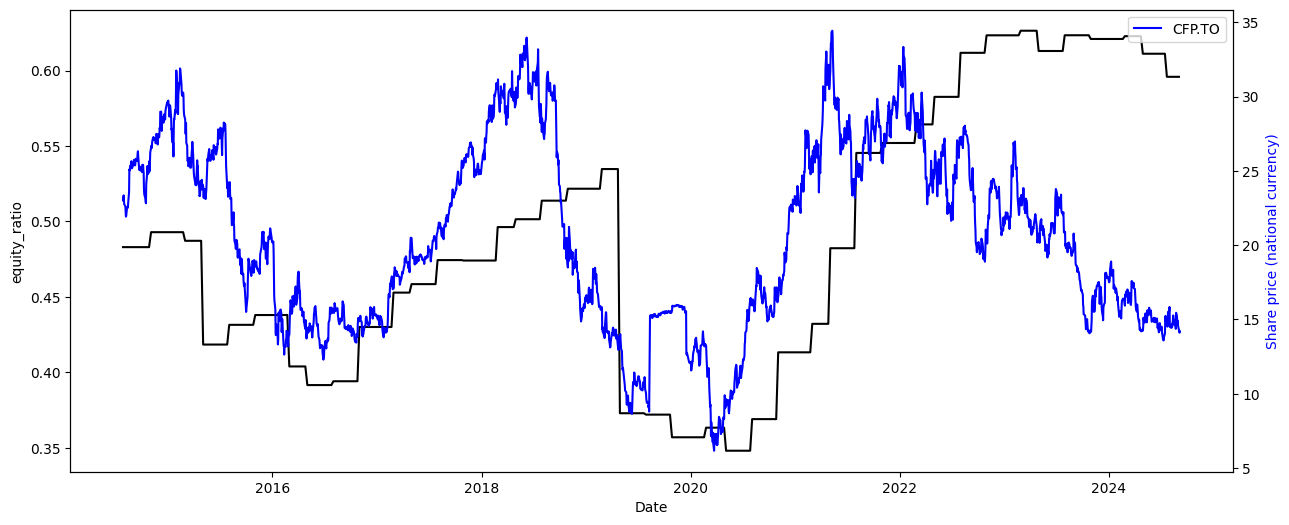

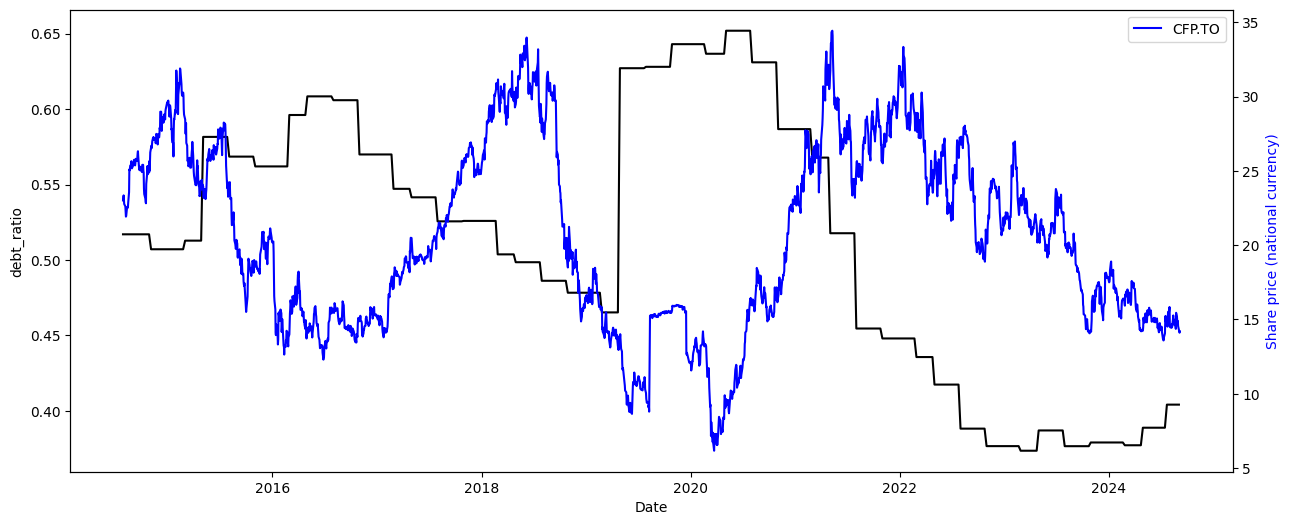

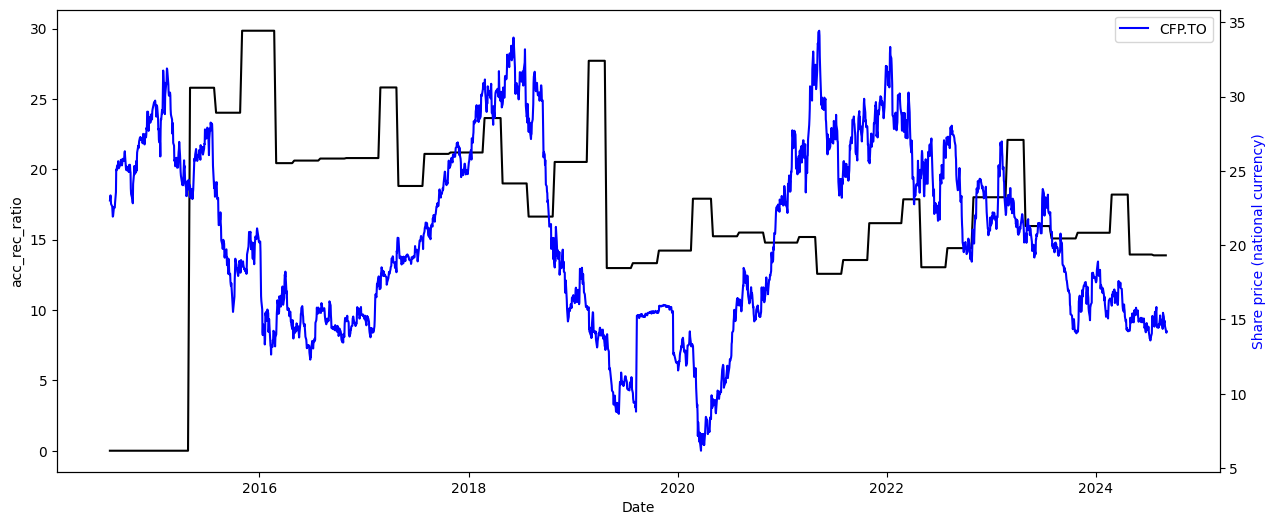

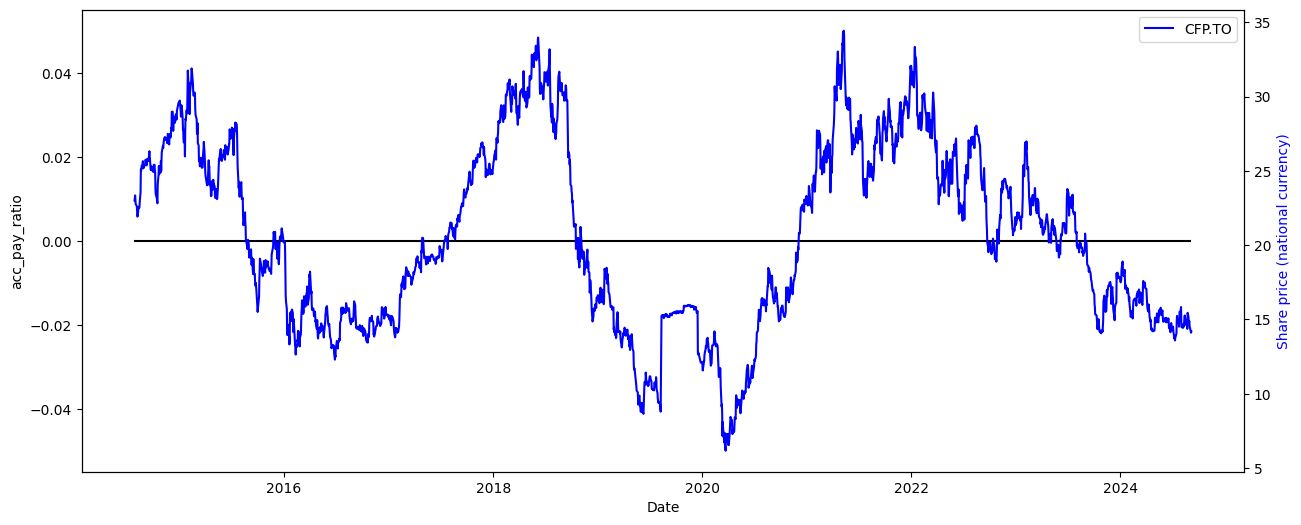

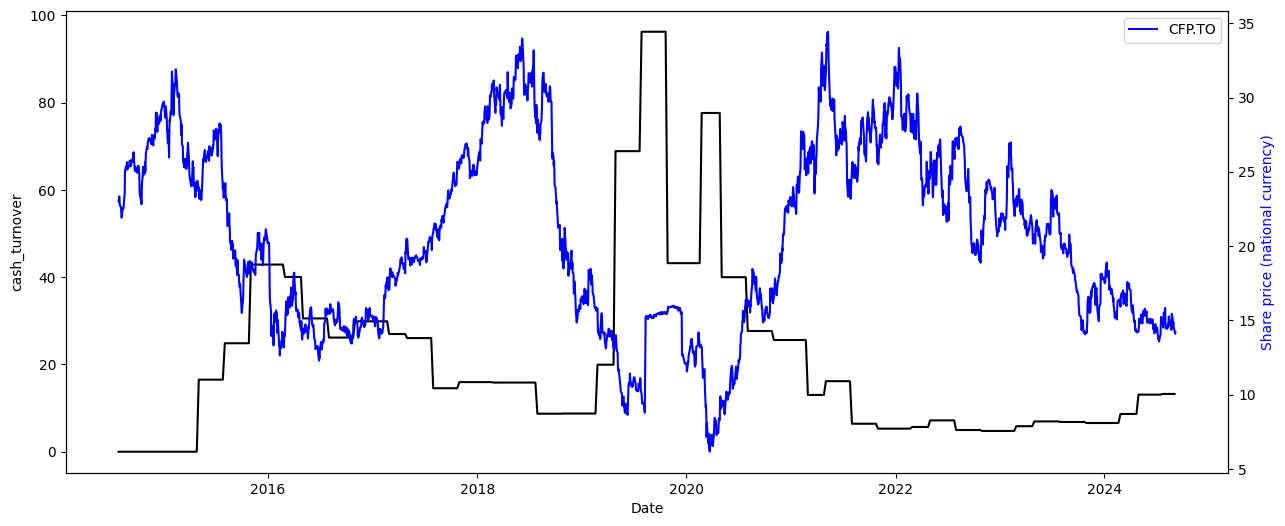

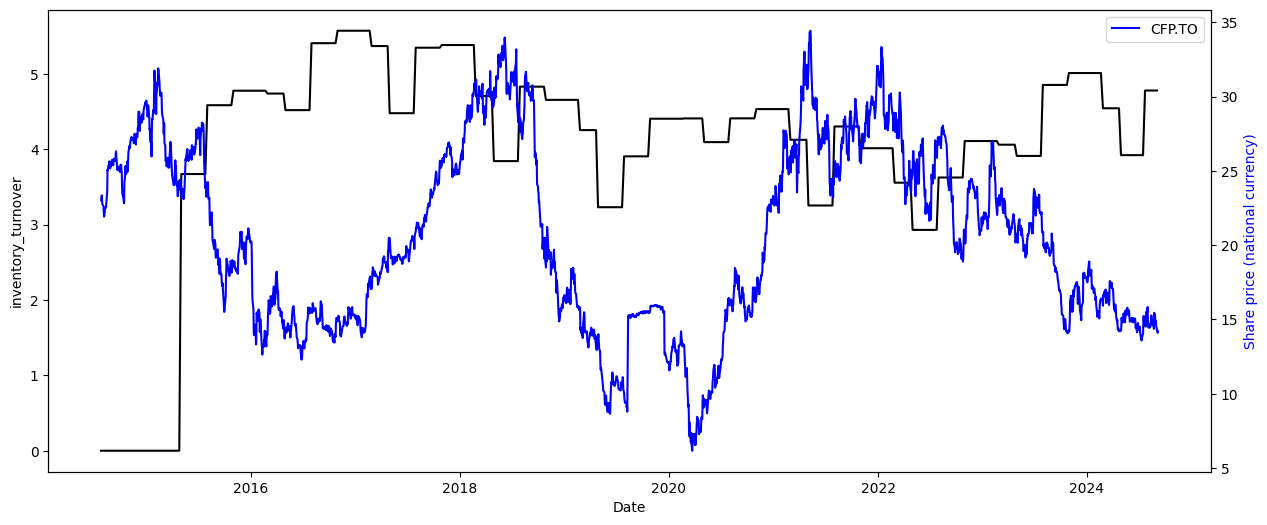

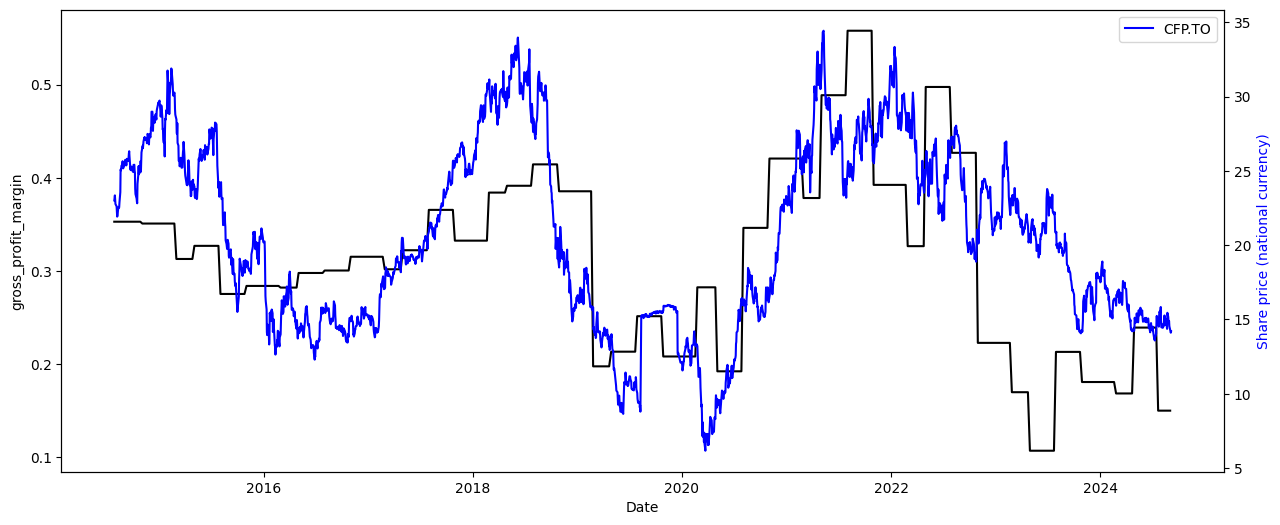

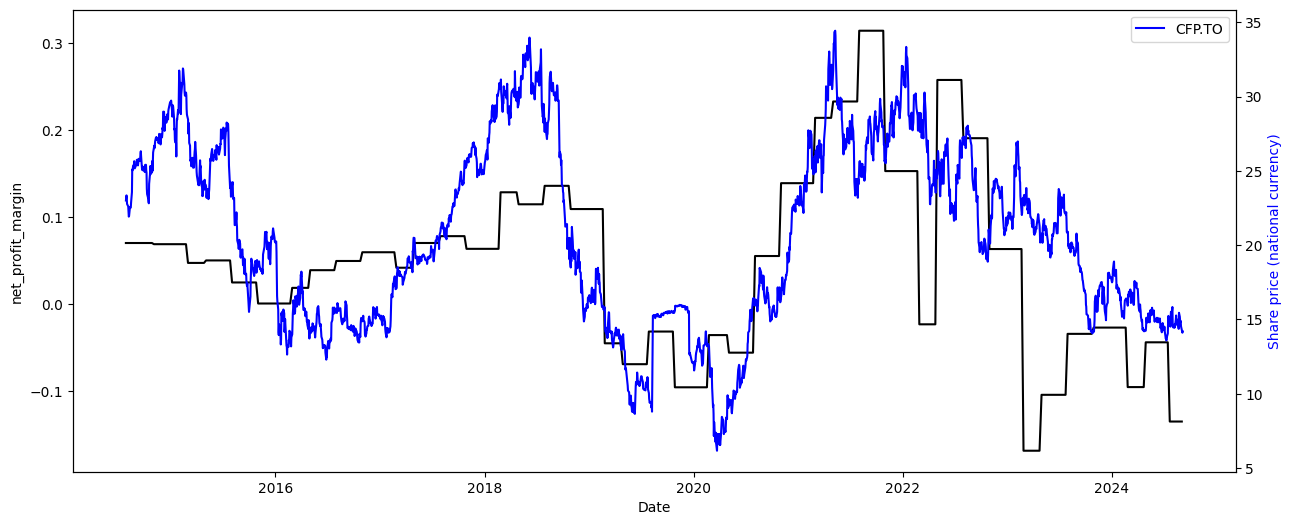

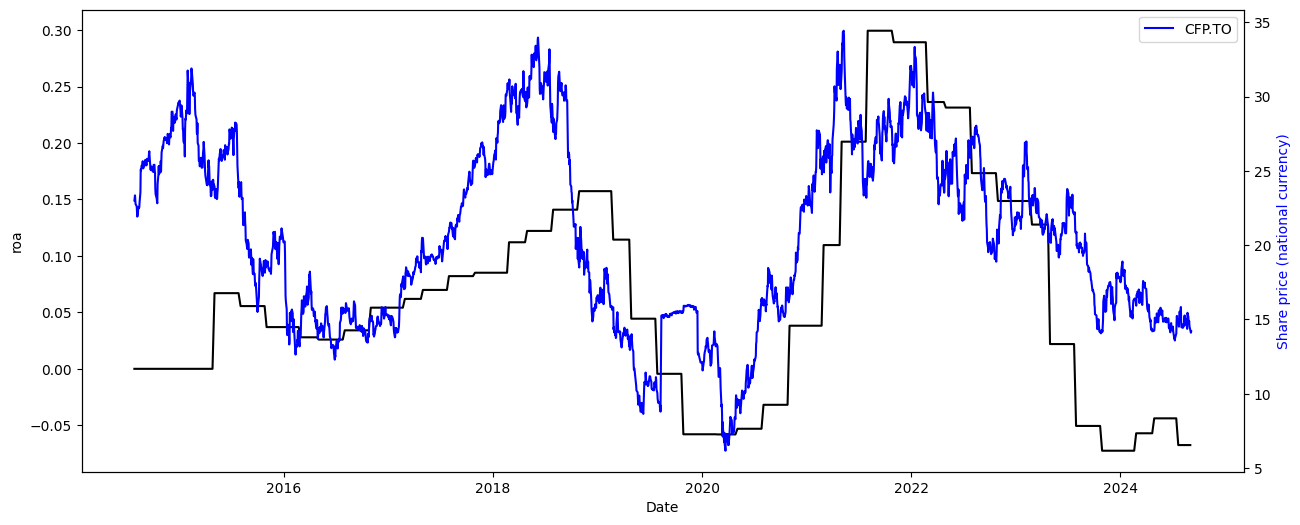

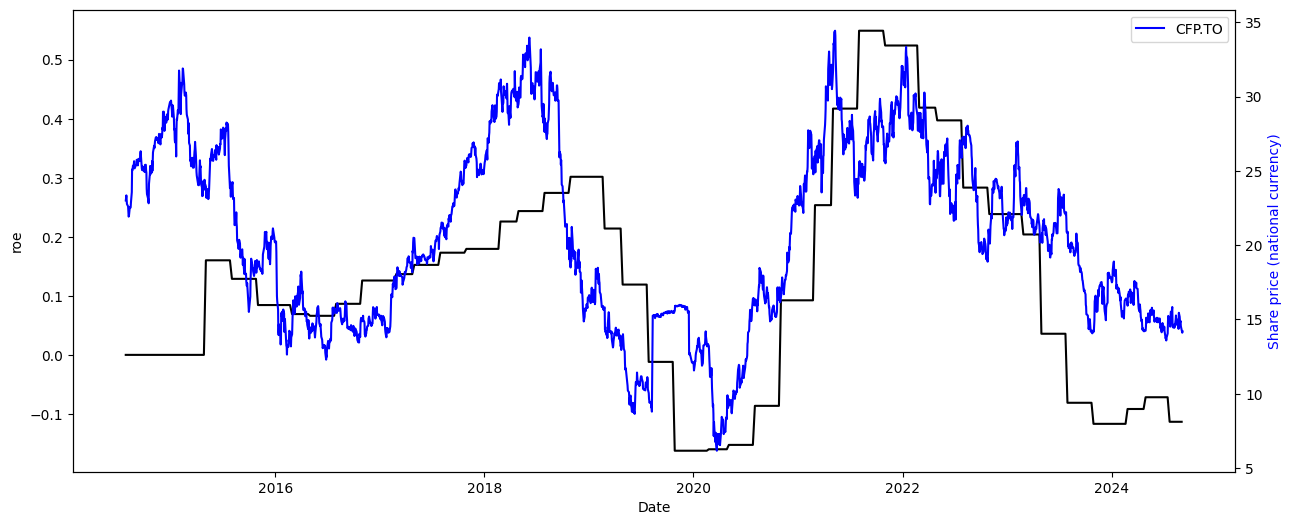

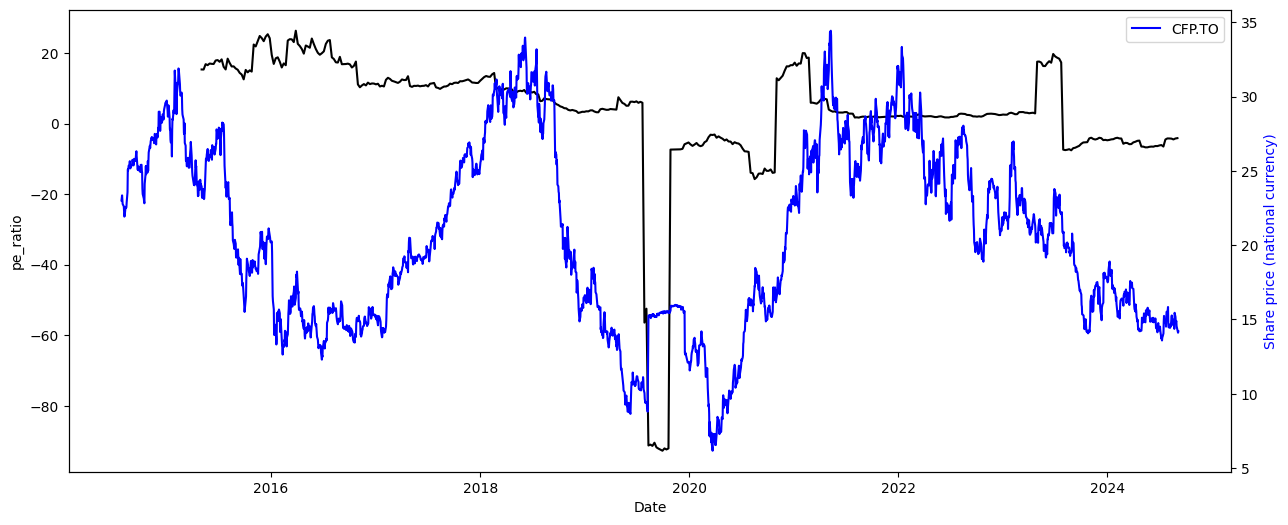

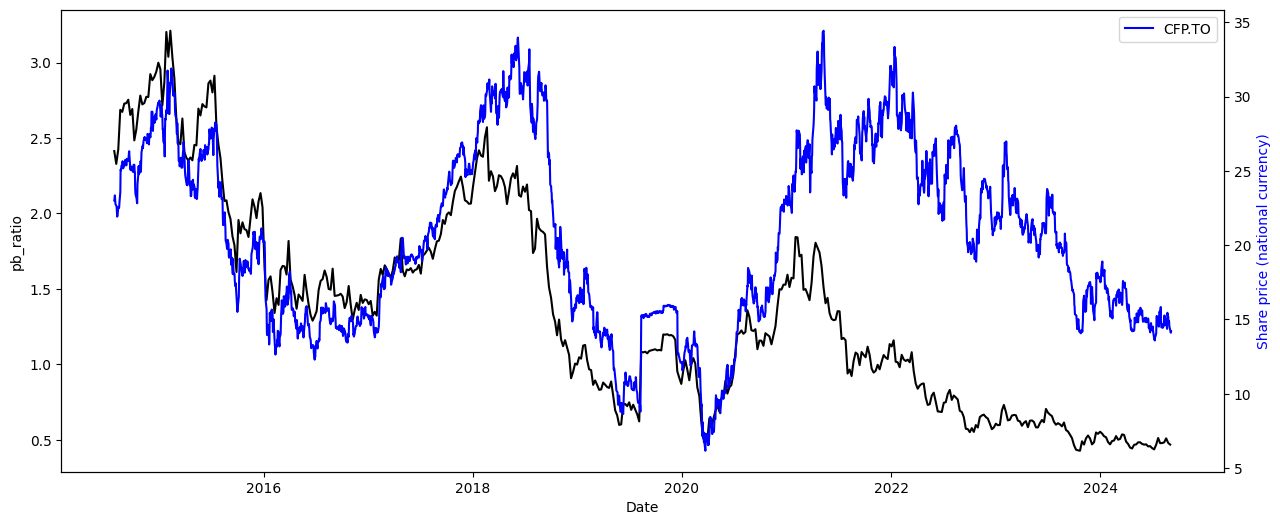

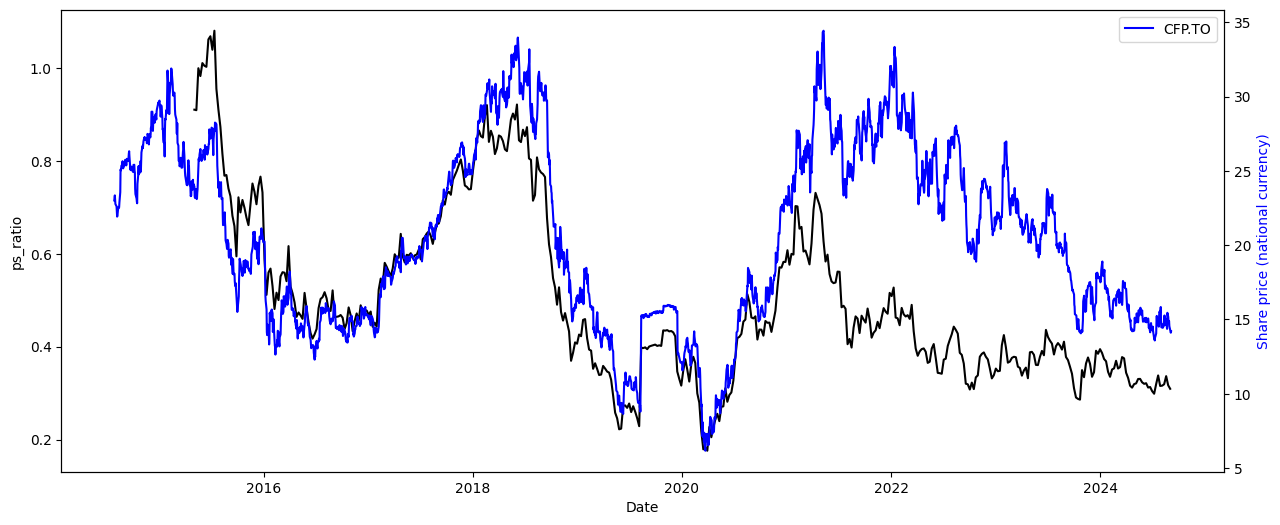

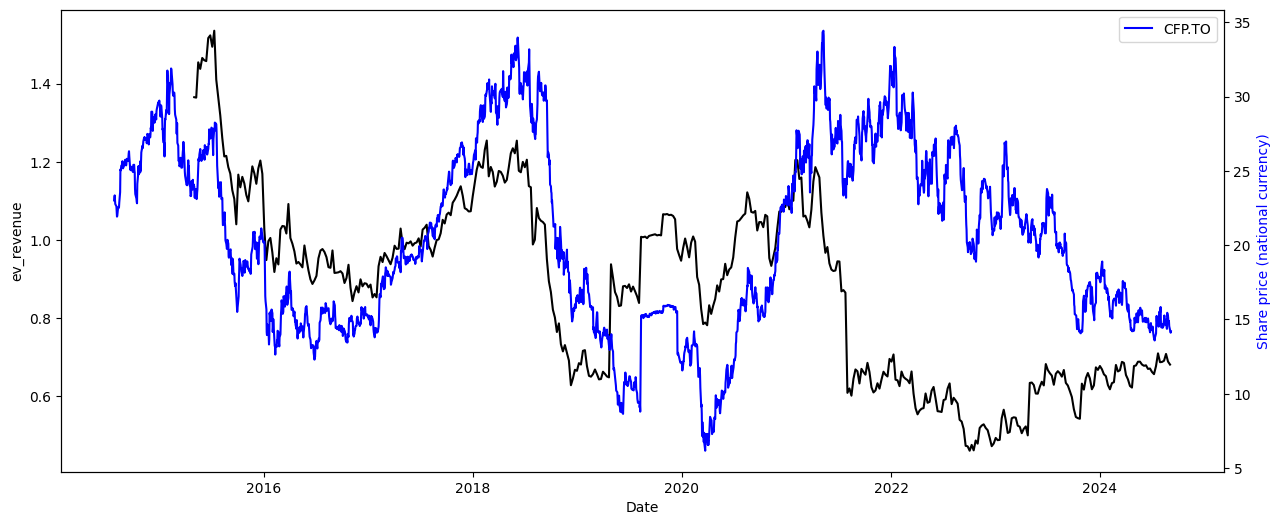

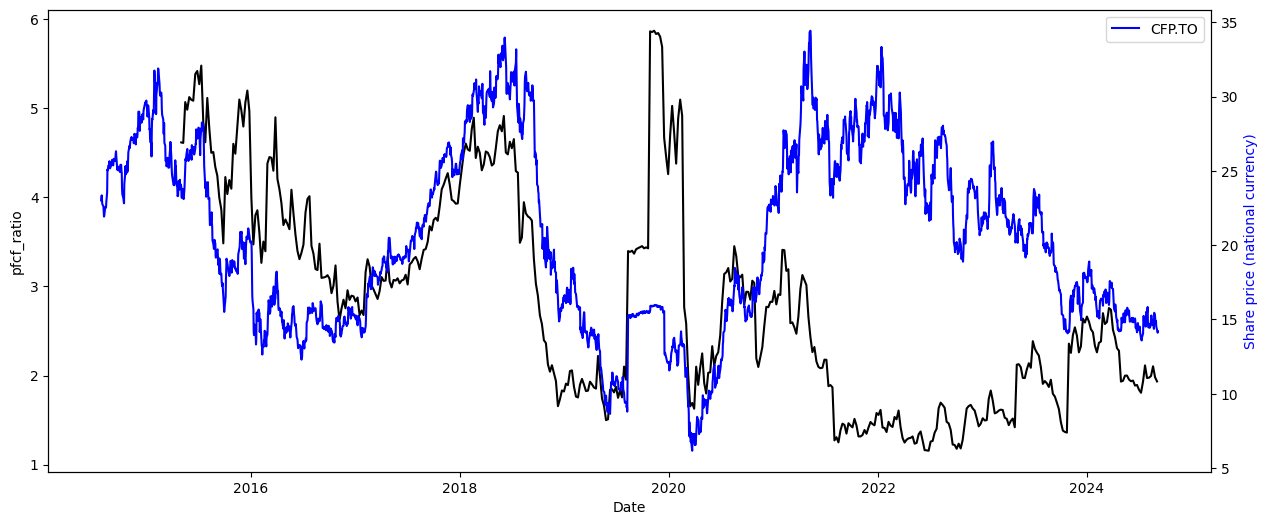

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

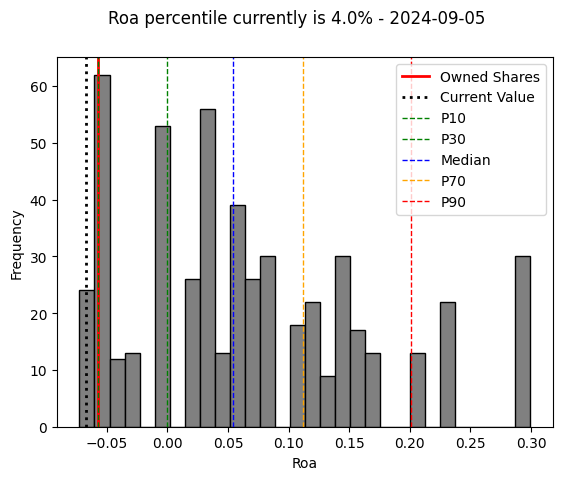

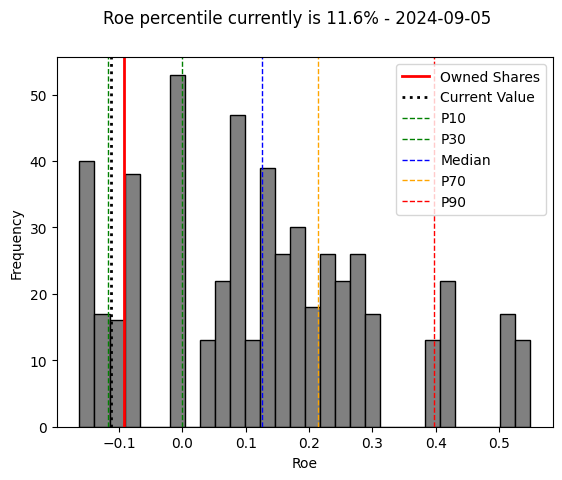

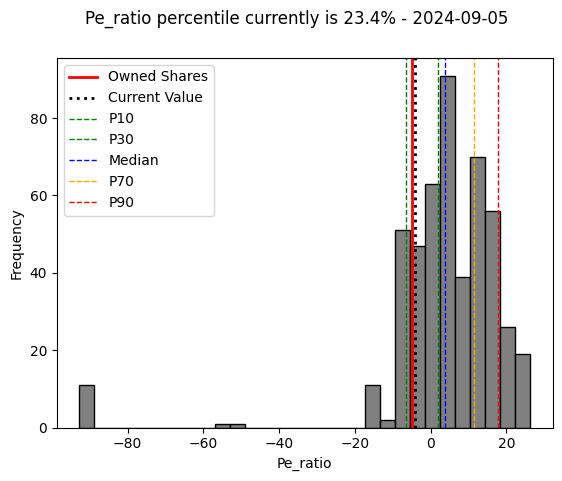

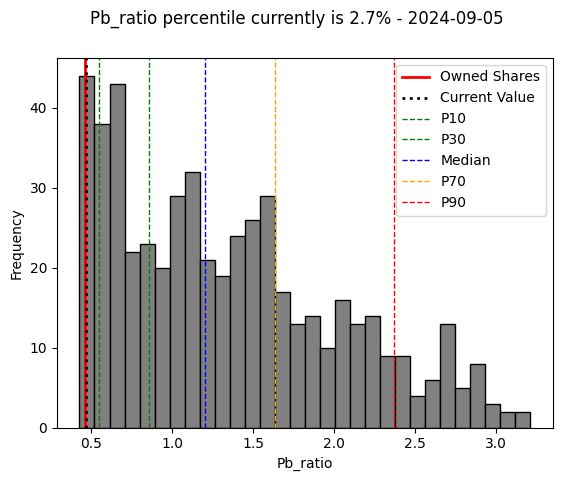

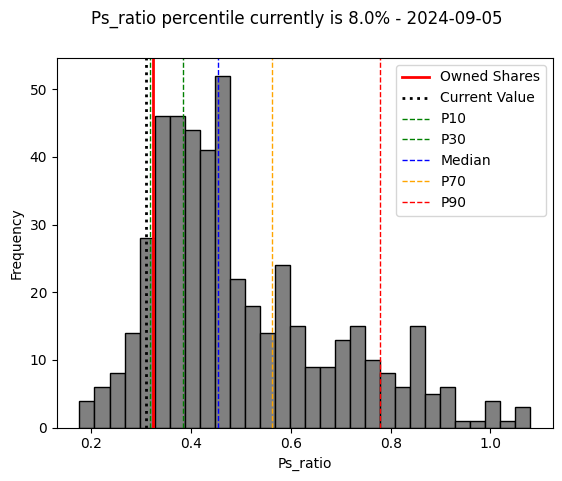

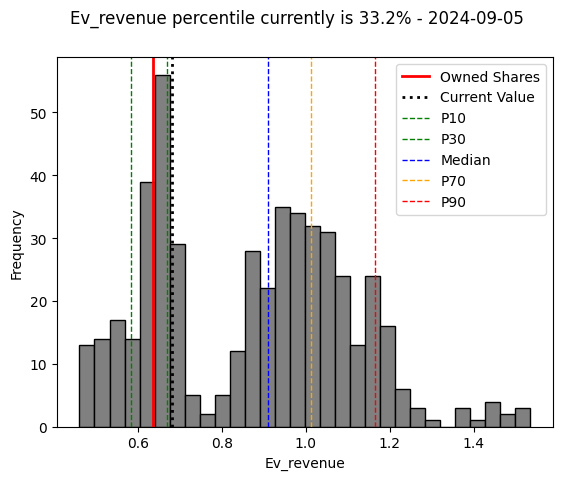

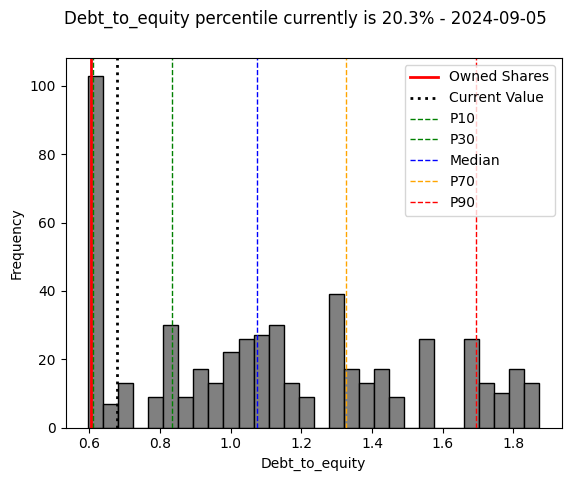

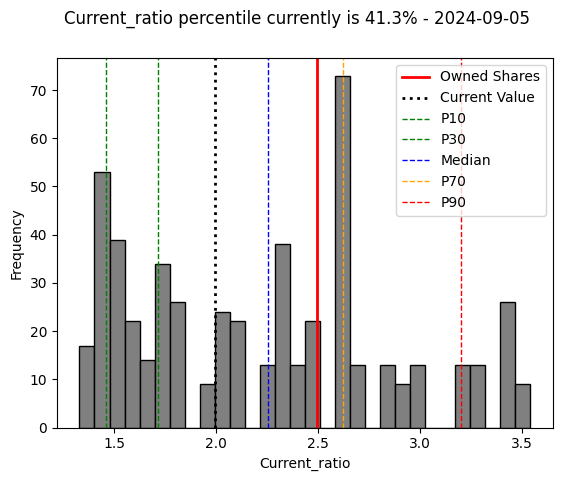

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.989554,0.188800,-0.004120,0.199134,-0.237452,-0.374924,0.466656
roe,0.989554,1.000000,0.232991,0.051589,0.272518,-0.172087,-0.372896,0.436362
pe_ratio,0.188800,0.232991,1.000000,0.373001,0.375885,0.161302,-0.108720,0.053545
pb_ratio,-0.004120,0.051589,0.373001,1.000000,0.950893,0.877088,0.263098,-0.326188
ps_ratio,0.199134,0.272518,0.375885,0.950893,1.000000,0.783415,0.101420,-0.127871
ev_revenue,-0.237452,-0.172087,0.161302,0.877088,0.783415,1.000000,0.656859,-0.662959
debt_to_equity,-0.374924,-0.372896,-0.108720,0.263098,0.101420,0.656859,1.000000,-0.837732
current_ratio,0.466656,0.436362,0.053545,-0.326188,-0.127871,-0.662959,-0.837732,1.000000


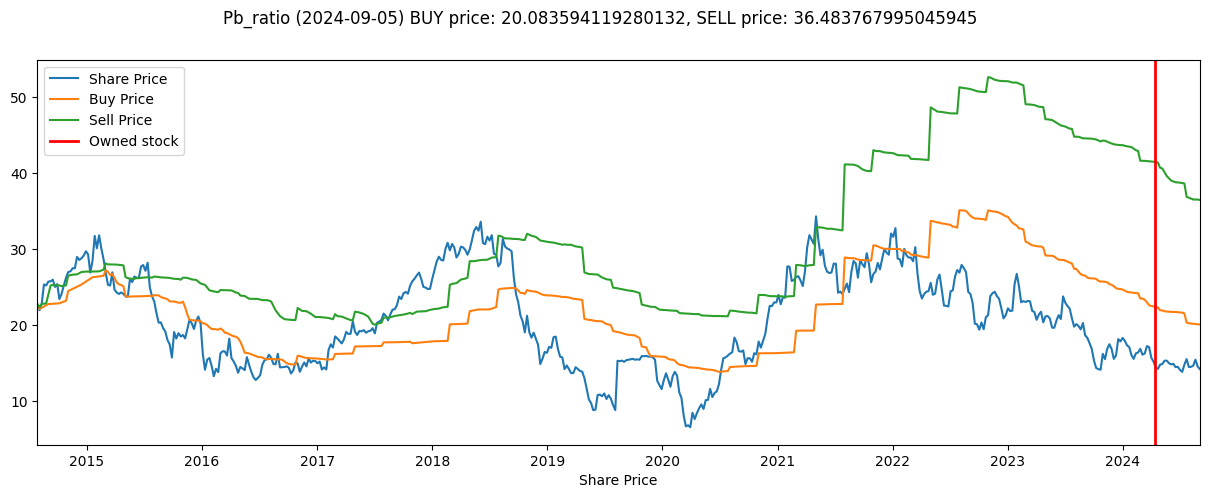

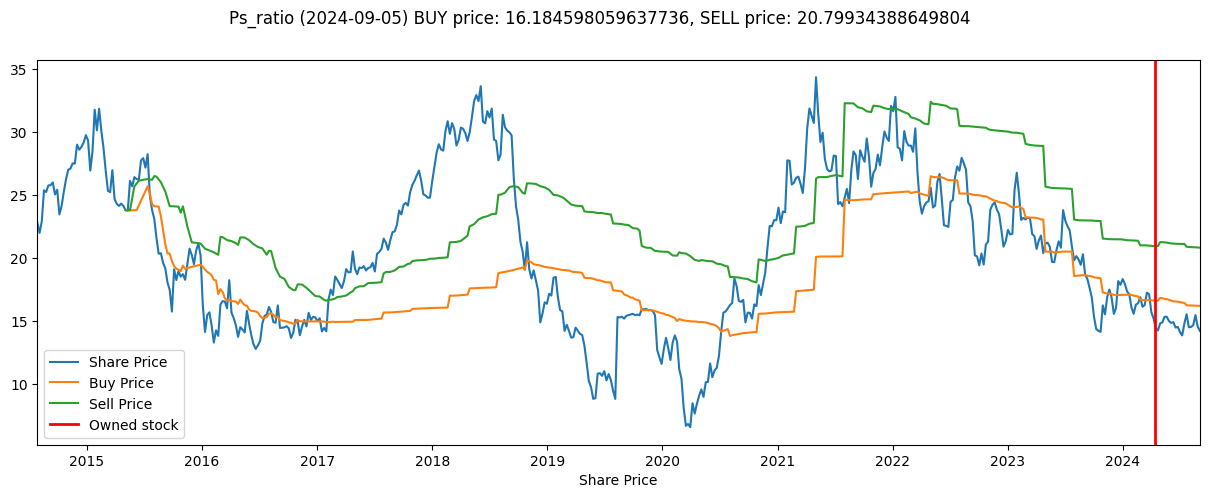

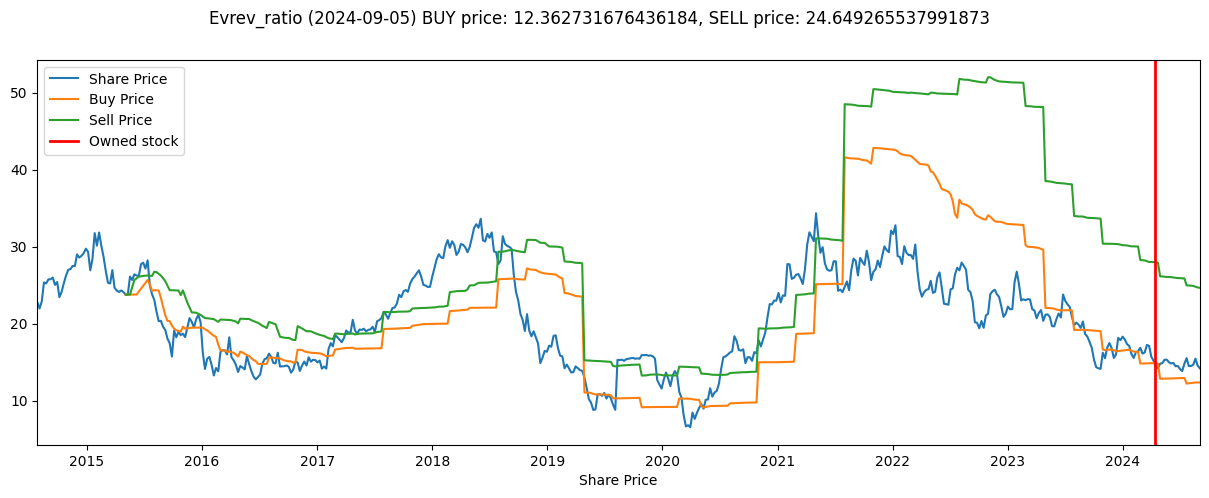

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)